<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e;'> 🌐 Styling, Links and Modules</h1>
---
#### [Keras. Applications](https://keras.io/applications/#inceptionv3)
#### [Extended version. Python](https://olgabelitskaya.github.io/kaggle_flowers.html) & [Extended version. R](https://olgabelitskaya.github.io/kaggle_flowers_R.html)
#### [Github Repository](https://github.com/OlgaBelitskaya/deep_learning_projects/tree/master/DL_PP0) & [Colaboratory Version](https://colab.research.google.com/drive/1H2ArWH_1kYfkIoCbxleX-aHAozRVBAdB)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Ewert|Roboto&effect=3d'); 
a,h4 {color:slategray; font-family:Roboto; text-shadow:4px 4px 4px #aaa;}
span {color:black; font-family:Roboto; text-shadow:4px 4px 4px #aaa;}
div.output_prompt,div.output_area pre {color:slategray;}
div.input_prompt,div.output_subarea {color:#ff355e;}      
div.output_stderr pre {background-color:gainsboro;}  
div.output_stderr {background-color:slategrey;}     
</style>

In [5]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import pylab as pl
import keras as ks,tensorflow as tf
import h5py,cv2; from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.preprocessing import image as kimage
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import BatchNormalization,Conv2D,Dense
from keras.layers import LSTM,Flatten,Activation,Dropout
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras.layers import MaxPooling2D,GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as iv3pi
fpath='../input/flower-color-images/flower_images/flower_images/'
fw='weights.best.flowers.hdf5'
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:', tf.__version__)

keras version: 2.4.3
tensorflow version: 2.2.0


In [6]:
def history_plot(fit_history):
    pl.figure(figsize=(12,9));pl.subplot(211)
    pl.plot(fit_history.history['loss'],
            color='slategray',label='train')
    pl.plot(fit_history.history['val_loss'],
            color='#ff355e',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')      
    pl.subplot(212)
    pl.plot(fit_history.history['acc'],
            color='slategray',label='train')
    pl.plot(fit_history.history['val_acc'], 
            color='#ff355e',label='valid')
    pl.xlabel('Epochs'); pl.ylabel('Accuracy')    
    pl.legend(); pl.title('Accuracy')
    pl.grid(); pl.show()
def path_to_tensor(img_path,fpath=fpath):
    img=kimage.load_img(fpath+img_path, 
                        target_size=(128,128))
    x=kimage.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths):
    tensor_list=[path_to_tensor(img_path) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True 

<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e;'> &#x1F310; &nbsp; Data Exploration</h1>

In [7]:
import pandas as pd
flowers=pd.read_csv(fpath+"flower_labels.csv")
flower_files=flowers['file']
flower_labels=flowers['label'].values
names=['phlox','rose','calendula','iris',
       'max chrysanthemum','bellflower','viola',
       'rudbeckia laciniata','peony','aquilegia']

In [8]:
# with h5py.File('../input/FlowerColorImages.h5','r') as f:
#     flower_images=f['images'].value
#     flower_labels=f['labels'].value 

Label:  3 iris


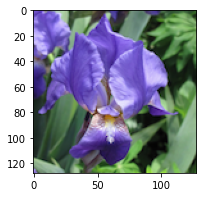

In [9]:
n=np.random.randint(0,210,1)[0]
print('Label: ',flower_labels[n],
      names[flower_labels[n]])
img=cv2.imread(fpath+flower_files[n])
rgb_img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pl.figure(figsize=(3,3))
pl.imshow(rgb_img);

In [10]:
flower_images=paths_to_tensor(flower_files)/255
flower_labels=to_categorical(flower_labels,10)

100%|██████████| 210/210 [00:01<00:00, 195.80it/s]


In [11]:
x_train,x_test,y_train,y_test=\
train_test_split(flower_images,flower_labels,
                 test_size=.2,random_state=1)
m=int(len(x_test)/2)
x_valid,y_valid=x_test[:m],y_test[:m]
x_test,y_test=x_test[m:],y_test[m:]
[x_train.shape,x_test.shape,x_valid.shape,
 y_train.shape,y_test.shape,y_valid.shape]

[(168, 128, 128, 3),
 (21, 128, 128, 3),
 (21, 128, 128, 3),
 (168, 10),
 (21, 10),
 (21, 10)]

Label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] aquilegia


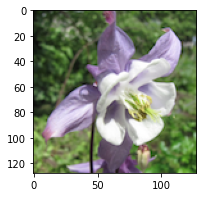

In [12]:
n=np.random.randint(0,168,1)[0]
print('Label: ',y_train[n],
      names[np.argmax(y_train[n])])
pl.figure(figsize=(3,3))
pl.imshow((x_train[n]));

<h1 class='font-effect-3d' style='font-family:Ewert; color:#ff355e;'> &#x1F310; &nbsp; Classification Models</h1>

In [13]:
def mlp_model():
    model=Sequential()    
    model.add(Dense(128,activation='relu',
                    input_shape=(128*128*3,)))
    model.add(BatchNormalization())    
    model.add(Dense(256,activation='relu'))
    model.add(BatchNormalization())    
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())   
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.2))     
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',metrics=['accuracy'])
    return model
mlp_model=mlp_model()

In [14]:
early_stopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
checkpointer=ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',verbose=2,
                               patience=5,factor=.8)
history=mlp_model.fit(x_train.reshape(-1,128*128*3),y_train,
                      epochs=100,batch_size=64,verbose=2,
                      validation_data=(x_valid.reshape(-1,128*128*3),y_valid),
                      callbacks=[checkpointer,early_stopping,lr_reduction])

Epoch 1/100

Epoch 00001: val_loss improved from inf to 5.42159, saving model to weights.best.flowers.hdf5
3/3 - 1s - loss: 2.3639 - accuracy: 0.1786 - val_loss: 5.4216 - val_accuracy: 0.0476 - lr: 0.0010
Epoch 2/100

Epoch 00002: val_loss improved from 5.42159 to 5.25753, saving model to weights.best.flowers.hdf5
3/3 - 0s - loss: 1.1878 - accuracy: 0.5952 - val_loss: 5.2575 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 3/100

Epoch 00003: val_loss did not improve from 5.25753
3/3 - 0s - loss: 0.5897 - accuracy: 0.8274 - val_loss: 5.3690 - val_accuracy: 0.2381 - lr: 0.0010
Epoch 4/100

Epoch 00004: val_loss did not improve from 5.25753
3/3 - 0s - loss: 0.3403 - accuracy: 0.8512 - val_loss: 6.1739 - val_accuracy: 0.1905 - lr: 0.0010
Epoch 5/100

Epoch 00005: val_loss did not improve from 5.25753
3/3 - 0s - loss: 0.1363 - accuracy: 0.9643 - val_loss: 7.1741 - val_accuracy: 0.2381 - lr: 0.0010
Epoch 6/100

Epoch 00006: val_loss did not improve from 5.25753
3/3 - 0s - loss: 0.1371 - accuracy: 

Epoch 42/100

Epoch 00042: val_loss did not improve from 2.93317
3/3 - 0s - loss: 5.2294e-04 - accuracy: 1.0000 - val_loss: 2.9467 - val_accuracy: 0.3333 - lr: 8.0000e-04
Epoch 43/100

Epoch 00043: val_loss improved from 2.93317 to 2.93301, saving model to weights.best.flowers.hdf5
3/3 - 1s - loss: 8.8660e-04 - accuracy: 1.0000 - val_loss: 2.9330 - val_accuracy: 0.3333 - lr: 8.0000e-04
Epoch 44/100

Epoch 00044: val_loss improved from 2.93301 to 2.90673, saving model to weights.best.flowers.hdf5
3/3 - 1s - loss: 7.8125e-04 - accuracy: 1.0000 - val_loss: 2.9067 - val_accuracy: 0.3810 - lr: 8.0000e-04
Epoch 45/100

Epoch 00045: val_loss improved from 2.90673 to 2.87460, saving model to weights.best.flowers.hdf5
3/3 - 0s - loss: 5.1470e-04 - accuracy: 1.0000 - val_loss: 2.8746 - val_accuracy: 0.3810 - lr: 8.0000e-04
Epoch 46/100

Epoch 00046: val_loss improved from 2.87460 to 2.84079, saving model to weights.best.flowers.hdf5
3/3 - 0s - loss: 8.6353e-04 - accuracy: 1.0000 - val_loss: 2.84

Epoch 82/100

Epoch 00082: val_loss did not improve from 1.96350
3/3 - 0s - loss: 1.8913e-04 - accuracy: 1.0000 - val_loss: 1.9679 - val_accuracy: 0.7619 - lr: 6.4000e-04
Epoch 83/100

Epoch 00083: val_loss did not improve from 1.96350

Epoch 00083: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
3/3 - 0s - loss: 2.0965e-04 - accuracy: 1.0000 - val_loss: 1.9693 - val_accuracy: 0.7619 - lr: 6.4000e-04
Epoch 84/100

Epoch 00084: val_loss did not improve from 1.96350
3/3 - 0s - loss: 1.9174e-04 - accuracy: 1.0000 - val_loss: 1.9714 - val_accuracy: 0.7619 - lr: 5.1200e-04
Epoch 85/100

Epoch 00085: val_loss did not improve from 1.96350
3/3 - 0s - loss: 7.5465e-04 - accuracy: 1.0000 - val_loss: 1.9754 - val_accuracy: 0.7619 - lr: 5.1200e-04
Epoch 86/100

Epoch 00086: val_loss did not improve from 1.96350
3/3 - 0s - loss: 3.6773e-04 - accuracy: 1.0000 - val_loss: 1.9810 - val_accuracy: 0.7619 - lr: 5.1200e-04
Epoch 87/100

Epoch 00087: val_loss did not improve from 1.96350

KeyError: 'acc'

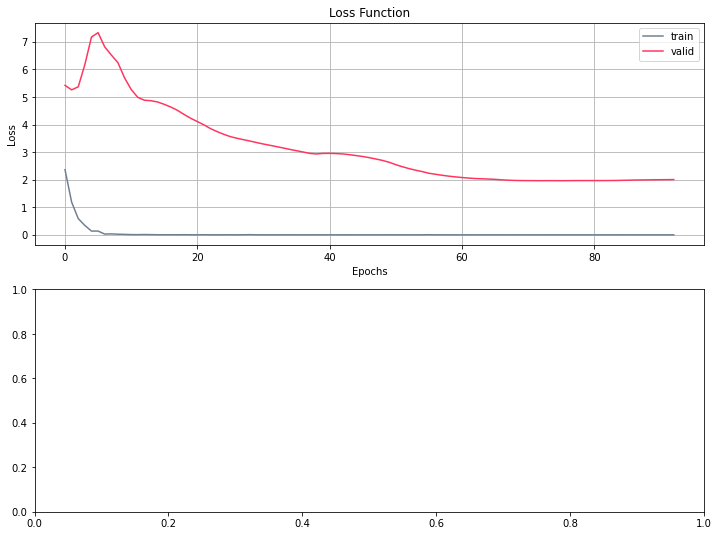

In [15]:
history_plot(history)
mlp_model.load_weights(fw)
mlp_model.evaluate(x_test.reshape(-1,128*128*3),y_test)

In [16]:
def cnn_model():
    model=Sequential()
    model.add(Conv2D(32,(5,5),padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64,(5,5),padding='same',
                     ))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))
    model.add(Dropout(.25))
    model.add(Conv2D(96,(5,5)))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.25))
    model.add(GlobalAveragePooling2D())    
    model.add(Dense(512,activation='tanh'))
    model.add(Dropout(.25))     
#    model.add(Dense(256,activation='tanh'))
#    model.add(Dropout(.25))     
    model.add(Dense(128,activation='tanh'))
    model.add(Dropout(.25)) 
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])    
    return model
cnn_model=cnn_model()

In [17]:
early_stopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
checkpointer=ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',verbose=2,
                               patience=5,factor=.8)
history=cnn_model.fit(x_train,y_train,epochs=100,batch_size=16,
                      verbose=2,validation_data=(x_valid,y_valid),
                      callbacks=[checkpointer,early_stopping,lr_reduction])

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.24010, saving model to weights.best.flowers.hdf5
11/11 - 4s - loss: 2.3069 - accuracy: 0.1488 - val_loss: 2.2401 - val_accuracy: 0.1905 - lr: 0.0010
Epoch 2/100

Epoch 00002: val_loss improved from 2.24010 to 2.05459, saving model to weights.best.flowers.hdf5
11/11 - 4s - loss: 2.1391 - accuracy: 0.2262 - val_loss: 2.0546 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 3/100

Epoch 00003: val_loss did not improve from 2.05459
11/11 - 4s - loss: 1.9047 - accuracy: 0.3274 - val_loss: 2.0838 - val_accuracy: 0.2381 - lr: 0.0010
Epoch 4/100

Epoch 00004: val_loss improved from 2.05459 to 1.80281, saving model to weights.best.flowers.hdf5
11/11 - 4s - loss: 1.7556 - accuracy: 0.3690 - val_loss: 1.8028 - val_accuracy: 0.3810 - lr: 0.0010
Epoch 5/100

Epoch 00005: val_loss improved from 1.80281 to 1.48669, saving model to weights.best.flowers.hdf5
11/11 - 4s - loss: 1.5987 - accuracy: 0.3988 - val_loss: 1.4867 - val_accuracy: 0.4286 - lr: 0.0

Epoch 45/100

Epoch 00045: val_loss did not improve from 0.84434

Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.
11/11 - 4s - loss: 0.6378 - accuracy: 0.7619 - val_loss: 0.8770 - val_accuracy: 0.7143 - lr: 4.0960e-04
Epoch 46/100

Epoch 00046: val_loss did not improve from 0.84434
11/11 - 4s - loss: 0.5967 - accuracy: 0.7798 - val_loss: 0.9861 - val_accuracy: 0.6190 - lr: 3.2768e-04
Epoch 47/100

Epoch 00047: val_loss did not improve from 0.84434
11/11 - 4s - loss: 0.6176 - accuracy: 0.7738 - val_loss: 0.8917 - val_accuracy: 0.6667 - lr: 3.2768e-04
Epoch 48/100

Epoch 00048: val_loss did not improve from 0.84434
11/11 - 4s - loss: 0.5807 - accuracy: 0.8095 - val_loss: 0.9223 - val_accuracy: 0.7143 - lr: 3.2768e-04
Epoch 49/100

Epoch 00049: val_loss did not improve from 0.84434
11/11 - 4s - loss: 0.5865 - accuracy: 0.7679 - val_loss: 0.8790 - val_accuracy: 0.6667 - lr: 3.2768e-04
Epoch 50/100

Epoch 00050: val_loss improved from 0.84434 to 0.83311, sav

In [ ]:
history_plot(history)
cnn_model.load_weights(fw)
cnn_model.evaluate(x_test,y_test)

In [ ]:
'''
generator=kimage.\
ImageDataGenerator(shear_range=.3,zoom_range=.3,
                   rotation_range=30,horizontal_flip=True)
ghistory=cnn_model.fit_generator(generator\
.flow(x_train,y_train,batch_size=64),\
steps_per_epoch=189,epochs=3,verbose=2,\
validation_data=(x_valid,y_valid),
callbacks=[checkpointer,early_stopping,lr_reduction])
'''
''' '''

In [ ]:
'''
cnn_model.load_weights(fw)
cnn_model.evaluate(x_test,y_test)
'''
''' '''

In [ ]:
y_test_predict=cnn_model.predict_classes(x_test)
fig=pl.figure(figsize=(14,7))
randch=np.random.choice(x_test.shape[0],size=8,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,4,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx=y_test_predict[idx]
    true_idx=np.argmax(y_test[idx])
    ax.set_title("{}\n({})".format(names[pred_idx],names[true_idx]),
                 color=("#4876ff" if pred_idx==true_idx else "darkred"))
pl.show()

In [ ]:
def rnn_model():
    model=Sequential()
    model.add(LSTM(196,return_sequences=True,
                   input_shape=(1,128*128*3))) 
    model.add(LSTM(196,return_sequences=True))
    model.add(LSTM(196))  
    model.add(Dense(512,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])    
    return model
rnn_model=rnn_model()

In [ ]:
early_stopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
checkpointer=ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',verbose=2,
                               patience=5,factor=.8)
history=rnn_model.fit(x_train.reshape(-1,1,128*128*3),y_train,
                      epochs=100,batch_size=64,verbose=2,
                      validation_data=(x_valid.reshape(-1,1,128*128*3),y_valid),
                      callbacks=[checkpointer,early_stopping,lr_reduction])

In [ ]:
history_plot(history)
rnn_model.load_weights(fw)
rnn_model.evaluate(x_test.reshape(-1,1,128*128*3),y_test)